# Host-Only LAISS, Dust-Corrected

In [12]:
import os

# a silly hack to switch the working directory to the one where this file is located
working_dir = os.path.abspath("")

import time
import datetime
import math
import numpy as np
import pandas as pd
import sys
import astro_ghost
import os
import subprocess
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.spatial.distance import euclidean
from dust_extinction.parameter_averages import G23
import astropy.units as u
from sfdmap2 import sfdmap
import corner
import matplotlib.pyplot as plt

os.chdir(working_dir)
sys.path.append('../code/')

from helper_functions import *
from laiss_functions import *
from mod_helper_functions import *
from mod_laiss_functions import *

import requests
from requests.auth import HTTPBasicAuth

import warnings
warnings.filterwarnings("ignore")

### Create raw dataset bank from GHOST

In [2]:
# from antares_client.search import cone_search
# from astropy.coordinates import Angle, SkyCoord
# from astro_ghost.ghostHelperFunctions import getGHOST, fullData

# getGHOST(real=True)
# GHOST = fullData()
# GHOST['ZTFID'] = ''

# # ZTF survey began in 2018!
# GHOST = GHOST[GHOST['TransientDiscoveryYear'] > 2017]
# # ZTF operates in the northern hemisphere
# GHOST = GHOST[GHOST['TransientDEC'] > -30]
# for idx, row in GHOST.iterrows():
#     center = SkyCoord(row.TransientRA, row.TransientDEC, unit=(u.deg, u.deg))
#     radius = Angle("2s")
#     loci = list(cone_search(center, radius))
#     if len(loci) > 0:
#         locus = loci[0]
#         print(f"Found properties for {row.TransientName}!")
#         GHOST.at[idx, 'ZTFID'] = locus.properties.get('ztf_object_id', '')
#     else:
#         print(f"No ZTF name found for {row.TransientName}.")
# GHOST.to_csv("../data/GHOST_withZTFNames.csv", index=False)

### Create host-only dataset bank by modifying GHOST dataset bank

In [3]:
# raw_dataset_bank = pd.read_csv("../data/GHOST_withZTFNames.csv")

# missing_ztf_ids = raw_dataset_bank["ztf_object_id"].isna().sum()
# pct_missing_ztf_ids = round((missing_ztf_ids / len(raw_dataset_bank)) * 100, 2)
# print("% of originial GHOST database missing ztf_id:", pct_missing_ztf_ids)

# raw_host_features = ['ztf_object_id']
# for band in ['g', 'r', 'i', 'z']:
#     for feat in ['momentXX', 'momentYY', 'momentXY', 'KronMag', 'KronRad', 'ExtNSigma']:
#         raw_host_features.append(band+feat)
# raw_host_features += ['TransientRA', 'TransientDEC']

# filtered_raw_dataset_bank = raw_dataset_bank[raw_host_features]

# # Create ell features
# wip_dataset_bank = filtered_raw_dataset_bank
# for band in ['g', 'r', 'i', 'z']:
#     xx = filtered_raw_dataset_bank[band+'momentXX']
#     yy = filtered_raw_dataset_bank[band+'momentYY']
#     xy = filtered_raw_dataset_bank[band+'momentXY']
#     wip_dataset_bank[band+'ell'] = np.sqrt(
#         (xx - yy)/(xx+yy)**2 + (2*xy)*2/(xx+yy)
#         )

# central_wv_filters = {
#      'g': 4849.11,
#      'r': 6201.20,
#      'i': 7534.96,
#      'z': 8674.20
# }
# def getExtinctionCorrectedMag(transient_row, band):
#     MW_RV = 3.1
#     ext = G23(Rv=MW_RV)

#     m = sfdmap.SFDMap('../data/sfddata-master')
#     MW_EBV = m.ebv(float(transient_row['TransientRA']), float(transient_row['TransientDEC']))

#     MW_AV = MW_RV*MW_EBV
#     wv_filter = central_wv_filters[band]
#     A_filter = -2.5*np.log10(ext.extinguish(wv_filter*u.AA, Av=MW_AV))

#     return transient_row[band+'KronMag'] - A_filter

# for band in ['g', 'r', 'i', 'z']:
#     wip_dataset_bank[band+'KronMagCorrected'] = wip_dataset_bank.apply(getExtinctionCorrectedMag, axis=1, args=(band,))

# # Create Mag difference features
# wip_dataset_bank['gminusrKronMag'] = wip_dataset_bank['gKronMag'] - wip_dataset_bank['rKronMag']
# wip_dataset_bank['rminusiKronMag'] = wip_dataset_bank['rKronMag'] - wip_dataset_bank['iKronMag']
# wip_dataset_bank['iminuszKronMag'] = wip_dataset_bank['iKronMag'] - wip_dataset_bank['zKronMag']

#wip_dataset_bank = wip_dataset_bank.dropna(subset=['ztf_object_id'])
# final_dataset_bank = wip_dataset_bank

# # Write dataset bank to .csv
# final_dataset_bank.to_csv('../data/dataset_bank_host_only_laiss.csv')

### Build indexed space for ANNOY

In [4]:
host_only_laiss_features = ['gKronMagCorrected', 
                            'gKronRad', 
                            'gExtNSigma', 
                            'gell', 
                            'rKronMagCorrected', 
                            'rKronRad', 
                            'rExtNSigma', 
                            'rell', 
                            'iKronMagCorrected', 
                            'iKronRad', 
                            'iExtNSigma', 
                            'iell', 
                            'zKronMagCorrected', 
                            'zKronRad', 
                            'zExtNSigma', 
                            'zell',
                            'gminusrKronMag', 
                            'rminusiKronMag', 
                            'iminuszKronMag']

use_pca = False
num_pca_components = 15

binary_index_path = "../data/"+host_only_build_indexed_sample(
                                fn='../data/dataset_bank_host_only_laiss.csv',
                                host_features=host_only_laiss_features,
                                pca=use_pca,
                                n_components= num_pca_components,
                                save=True,
                                force_recreation_of_index=False
                                )

Loading previously saved ANNOY index


### Run Host-Only LAISS

In [ ]:
bank_df = pd.read_csv('../data/dataset_bank_host_only_laiss.csv')
print("Number of transients in ANNOY index for neighbor search:", bank_df.dropna().shape[0])

# Set up file structure for the GHOST code that associates transients with their host galaxies.
host_path = "../data/host_info"
if not os.path.exists(host_path):
    os.makedirs(host_path)
os.environ['GHOST_PATH'] = host_path


# Get primer dictionary. Note that only transients in the dataset bank can be passed into this function right now because
# ... for transients not in the dataset it uses extract_lc_and_host_features() which extracts the original LAISS features,
# ... not the new, host-only ones.
laiss_dict = host_only_LAISS_primer(
    ztf_id = 'ZTF18abvdmfx', # Any ztf_id in dataset bank of 2771 transients (must have no na values if using pca)
    dataset_bank_path='../data/dataset_bank_host_only_laiss.csv',
    host_features = host_only_laiss_features
)

host_neighbors = host_only_LAISS_nearest_neighbors(
    laiss_dict=laiss_dict,
    use_pca_for_nn=use_pca,
    n_components=num_pca_components,
    annoy_index_file_path=binary_index_path,
    n=8,
    search_k=5000,
    return_results=True,
)

Number of transients in ANNOY index for neighbor search: 1011
ZTF18abvdmfx is in dataset_bank. Continuing...
Created output dictionary!
Loading previously saved ANNOY LC+HOST index without PCA:
../data/host_only_laiss_annoy_index_pcaFalse.ann
					   ZTFID IAU_NAME SPEC Z
HOST REF: https://alerce.online/object/ZTF18abvdmfx 2018cvn SN II 0.019
ANN=1: https://alerce.online/object/ZTF18absoocp 2018cew SN Ib, None
ANN=2: https://alerce.online/object/ZTF19acynije 2019wup SN Ia, 0.02
ANN=3: https://alerce.online/object/ZTF20aabqwtz 2020by SN II, 0.0272
ANN=4: https://alerce.online/object/ZTF18abcvwcy 2018bdm SN Ia-pec, 0.034
ANN=5: https://alerce.online/object/ZTF19acxzafe 2019wle SN Ia, 0.067
ANN=6: https://alerce.online/object/ZTF19aapadxs 2019daf SN IIb, 0.035
ANN=7: https://alerce.online/object/ZTF19abrdxbh 2019ofm SN Ia-Ca-rich, 0.03025

ANN elapsed_time = 0.054 s

total elapsed_time = 2.603 s

  input_host_ztf_id  neighbor_num                                   ztf_link  \
0      ZTF18a

### Create corner plot from host only neighbor search

Creating corner plot for batch_1...
Shape after outlier removal: (1281, 4)


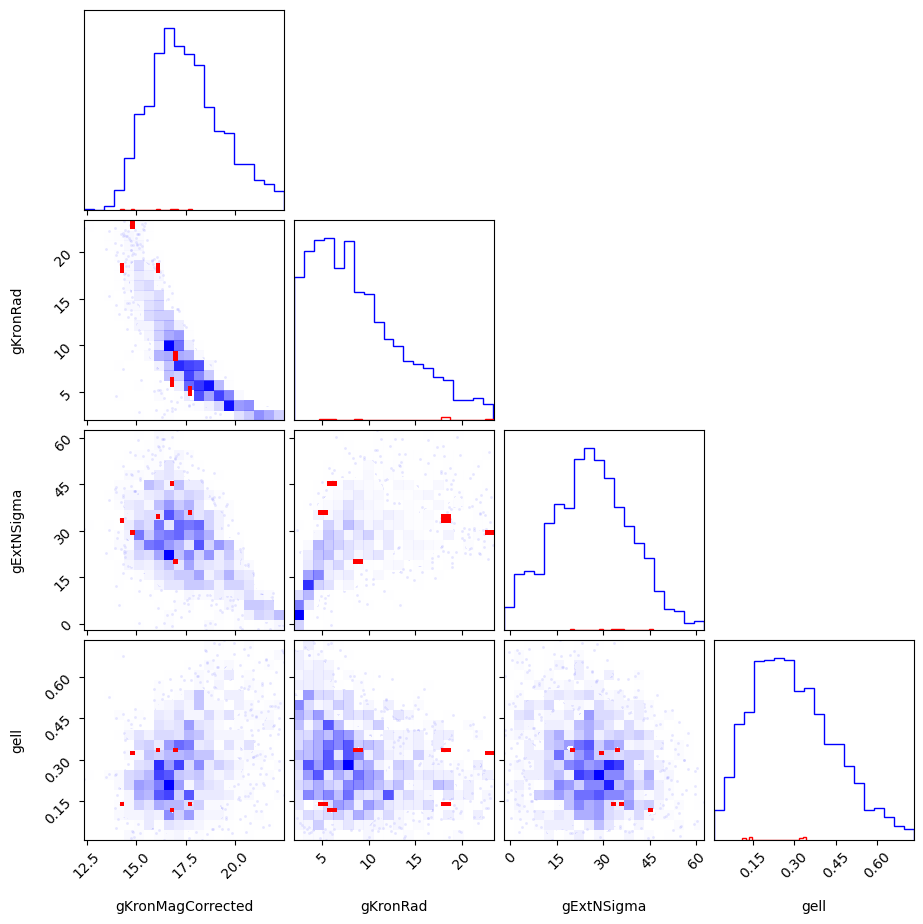

Creating corner plot for batch_2...
Shape after outlier removal: (1278, 4)


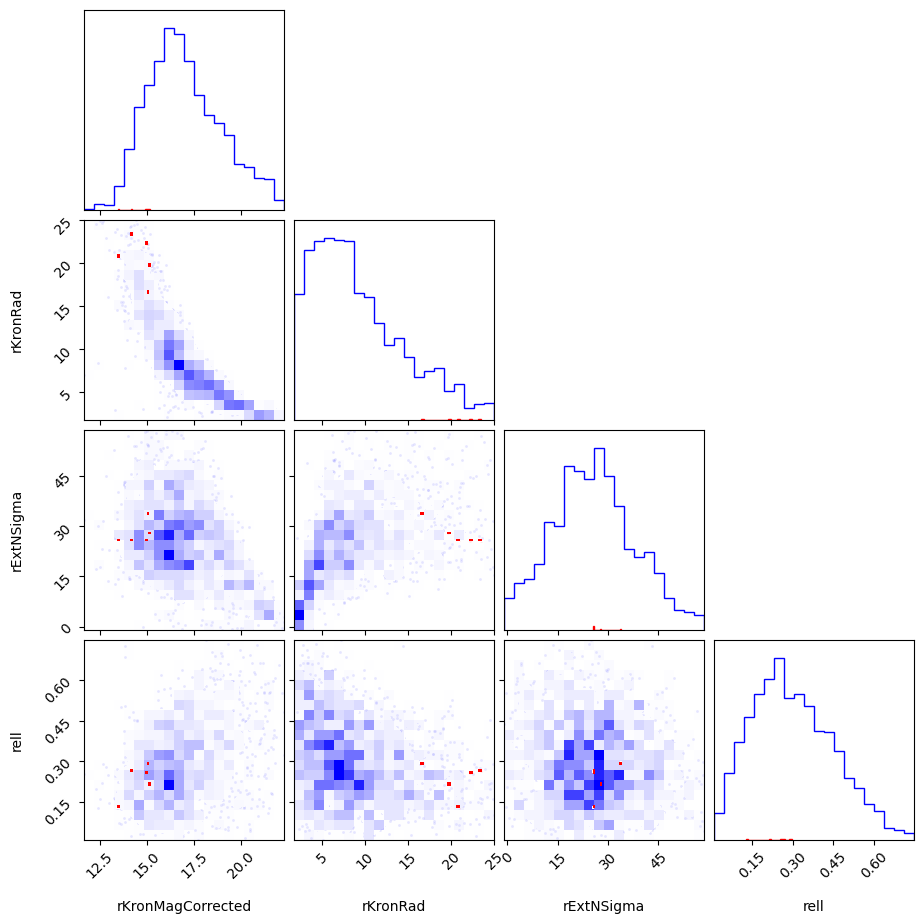

Creating corner plot for batch_3...
Shape after outlier removal: (1264, 4)


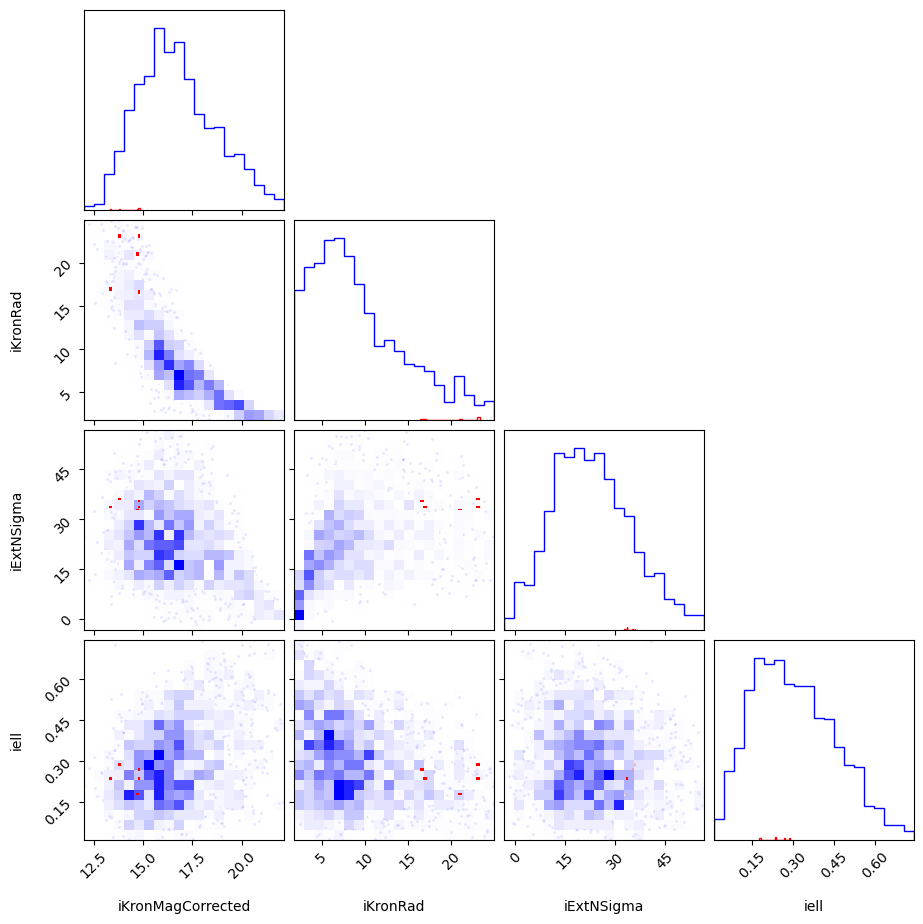

Creating corner plot for batch_4...
Shape after outlier removal: (1275, 4)


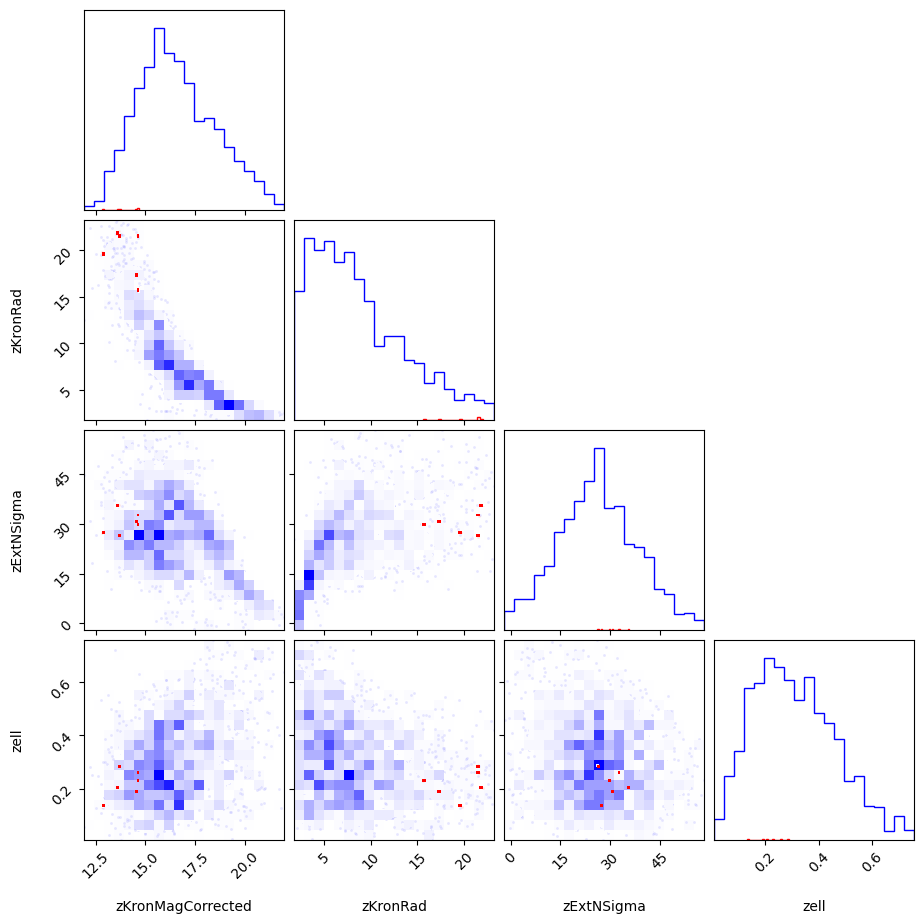

Creating corner plot for batch_5...
Shape after outlier removal: (2233, 3)


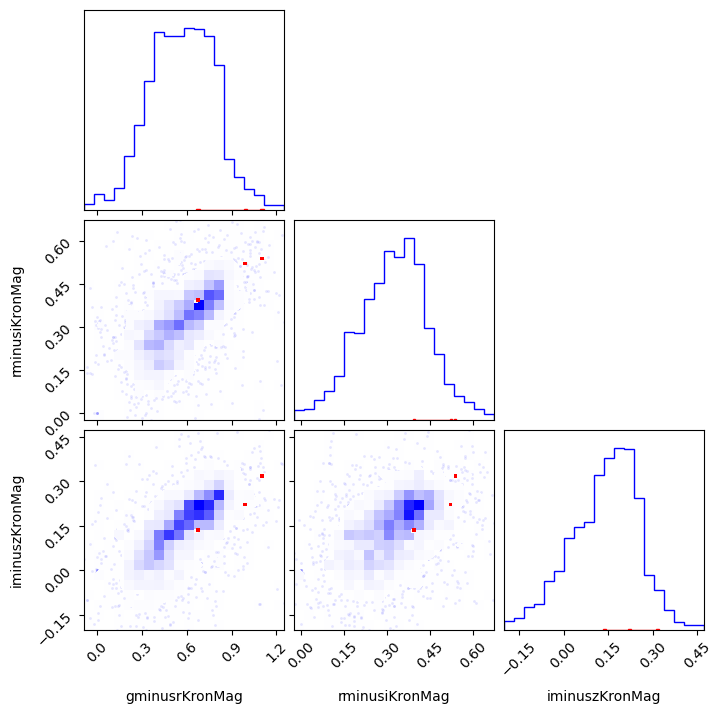

Finished creating all plots!


In [30]:
import logging
logging.getLogger().setLevel(logging.ERROR)

host_only_laiss_features = {
    'batch_1': ['gKronMagCorrected', 'gKronRad', 'gExtNSigma', 'gell'],
    'batch_2': ['rKronMagCorrected', 'rKronRad', 'rExtNSigma', 'rell'],
    'batch_3': ['iKronMagCorrected', 'iKronRad', 'iExtNSigma', 'iell'],
    'batch_4': ['zKronMagCorrected', 'zKronRad', 'zExtNSigma', 'zell'],
    'batch_5': ['gminusrKronMag', 'rminusiKronMag', 'iminuszKronMag']
}

neighbor_ztfids = [link.split("/")[-1] for link in host_neighbors["ztf_link"]]
dataset_bank_df = pd.read_csv('../data/dataset_bank_host_only_laiss.csv')

for batch_name, features in host_only_laiss_features.items():
    print(f"Creating corner plot for {batch_name}...")

    dataset_bank_df_host_features = dataset_bank_df[['ztf_object_id'] + features]
    neighbor_mask = dataset_bank_df_host_features['ztf_object_id'].isin(neighbor_ztfids)

    features_df = dataset_bank_df_host_features[features]
    features_df = features_df.replace([np.inf, -np.inf], np.nan).dropna()
    # Remove outliers in features_df
    Q1 = features_df.quantile(0.25)
    Q3 = features_df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    features_df = features_df[~((features_df < lower_bound) | (features_df > upper_bound)).any(axis=1)]
    print(f"Shape after outlier removal: {features_df.shape}")

    neighbor_features = features_df[neighbor_mask]
    non_neighbor_features = features_df[~neighbor_mask]

    figure = corner.corner(non_neighbor_features, color='blue', labels=features, plot_datapoints=True, alpha=0.5, plot_contours=False) # or levels=[0.1, 0.5, 0.9] for contours
    corner.corner(neighbor_features, color='red', labels=features, plot_datapoints=True, alpha=1.0, fig=figure, plot_contours=False) # or levels=[0.1, 0.5, 0.9] for contours
    plt.show()

print("Finished creating all plots!")
